In [14]:
import glob
import os
from tqdm import tqdm
import cv2
import numpy as np
import insightface
from matplotlib import pyplot as plt
from insightface.app import FaceAnalysis
from insightface.data import get_image as get_image
import pickle

### Расчет эмбеддингов AcrFace для датасета LFW

In [2]:
handler = insightface.model_zoo.get_model('w600k_r50.onnx')
handler.prepare(ctx_id=0)

c:\ML_stuff\BHACK_2\insface\Lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


In [3]:
embed_dict = {}

for person_name in tqdm(os.listdir("cropped_faces")):
    person_folder = "cropped_faces/" + person_name
    embed_dict.update({person_name : {}})
    for img_name in os.listdir(person_folder):
        img_path = person_folder + "/" + img_name
        img = cv2.imread(img_path)
        vec = handler.get_feat(img)[0]
        embed_dict[person_name].update({img_name : vec})

100%|██████████| 5749/5749 [15:20<00:00,  6.25it/s]   


In [ ]:
embed_dict.pop('Larry_Hahn')

In [ ]:
# Сохраняем эмбеддинги

with open('emb_data.pkl', 'wb') as f:
    pickle.dump(embed_dict, f)

In [66]:
with open('emb_data.pkl', 'rb') as f:
    embed_dict = pickle.load(f)

### Расчитываем дистанции между парами изображений одинаковых/разных людей

In [51]:
def eq_dist(embed_dict):
    all_dist = []
    for person in embed_dict.keys():
        emb = []
        for img in embed_dict[person].keys():
            emb.append(embed_dict[person][img])
        for i in range(len(emb)):
            for j in range(i + 1, len(emb)):
                source = emb[i]
                target = emb[j]
                num_dist = (np.sum(np.multiply(target, source))) / (np.sqrt(np.sum(np.multiply(target, target))) * np.sqrt(np.sum(np.multiply(source, source))))
                all_dist.append(num_dist)
    return all_dist

In [55]:
def neq_dist(embed_dict):
    all_dist = []
    for person in embed_dict.keys():
        if(len(all_dist) > 250000):
            break
        emb = embed_dict[person][list(embed_dict[person].keys())[0]]
        for p in embed_dict.keys():
            if (p != person):
                source = emb
                target = embed_dict[p][list(embed_dict[p].keys())[0]]
                num_dist = (np.sum(np.multiply(target, source))) / (np.sqrt(np.sum(np.multiply(target, target))) * np.sqrt(np.sum(np.multiply(source, source))))
                all_dist.append(num_dist)
    return all_dist

In [56]:
eq_d = eq_dist(embed_dict)
neq_d = neq_dist(embed_dict)

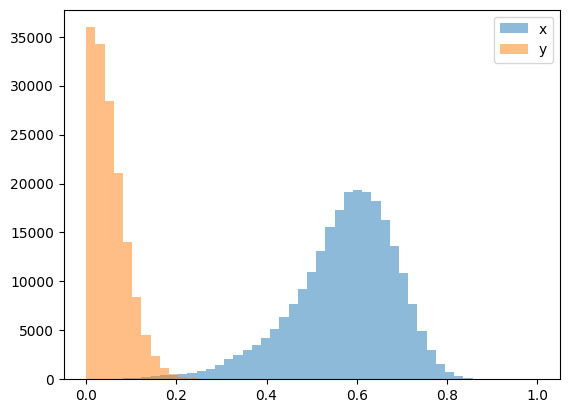

In [58]:
bins = np.linspace(0, 1, 50)

plt.hist(eq_d, bins, alpha=0.5, label='x')
plt.hist(neq_d, bins, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.show()

### Пороговое значение косинуса получаем перебором возможных значении и выбором лучшего по accuracy

In [60]:
def accuracy(eq_d, neq_d, p):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for d in eq_d:
        if (d >= p):
            tp += 1
        else:
            fn += 1
    for d in neq_d:
        if (d < p):
            tn += 1
        else:
            fp += 1
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    return accuracy

In [62]:
max_acc = 0
max_p = 0
for i in range(100):
    p = i / 100
    acc = accuracy(eq_d, neq_d, p)
    if (acc > max_acc):
        max_acc = acc
        max_p = p
print([max_p, max_acc])

[0.2, 0.9950410652317064]


### Итоговое пороговое значение косинуса 0.2

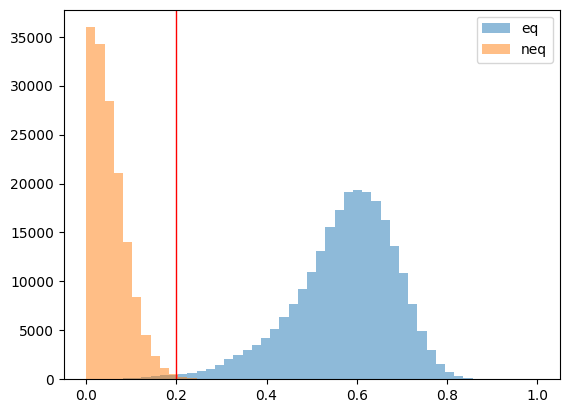

In [65]:
bins = np.linspace(0, 1, 50)

plt.hist(eq_d, bins, alpha=0.5, label='eq')
plt.hist(neq_d, bins, alpha=0.5, label='neq')
plt.axvline(max_p, color='r', linewidth=1)
plt.legend(loc='upper right')
plt.show()